<a href="https://colab.research.google.com/github/MostafaAbdelmegeed/Advanced-Data-Analysis-Deliveries/blob/master/RFM_Deepdive_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
# Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import auth
from datetime import date, timedelta
import bigframes.pandas as bpd
from google.cloud import bigquery
from google.colab import syntax
import umap

# Magics
%load_ext google.colab.data_table

# Config
# ────────────────────────────
# PROJECT & OPTIONS
# ────────────────────────────
project_id = "mh-tech-interviews"
bpd.options.bigquery.project = project_id
bpd.options.bigquery.progress_bar = True          # show job spinners
bpd.options.bigquery.use_bqstorage_api = True     # fast reads for big DFs
bigquery_quota = 200                              # in MBs
seed = 92

# ────────────────────────────
# PARAMETERISE DATE WINDOW
# ────────────────────────────
start = date(2020, 11, 2)   # inclusive 2020-11-02
end   = date(2021,  1, 31)  # inclusive 2021-01-30
cutoff_dt = (end + timedelta(days=1)).strftime("%Y-%m-%d")

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [2]:
# ────────────────────────────
# AUTHENTICATION
# ────────────────────────────
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
# ────────────────────────────
# CORE QUERY
# ────────────────────────────
start_sfx = start.strftime("%Y%m%d")
end_sfx   = end.strftime("%Y%m%d")

base_query = syntax.sql(f"""
WITH raw_purchases AS (
  SELECT
    user_pseudo_id,
    ecommerce.transaction_id                       AS tx_id,
    PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)            AS purchase_date,
    ecommerce.purchase_revenue_in_usd              AS revenue
  FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
  WHERE _TABLE_SUFFIX BETWEEN '{start_sfx}' AND '{end_sfx}'
    AND event_name = 'purchase'
    AND ecommerce.transaction_id IS NOT NULL       -- guards against null TX IDs
    AND ecommerce.purchase_revenue_in_usd <> 0
),

-- 1 row per (user, transaction)  ────────
dedup AS (
  SELECT
    user_pseudo_id,
    tx_id,
    MIN(purchase_date)          AS purchase_date,
    MAX(revenue)                AS revenue      -- one full-order value
  FROM raw_purchases
  GROUP BY user_pseudo_id, tx_id
)

-- Final RFM roll-up  ────────────────────
SELECT
  user_pseudo_id,
  DATE_DIFF(DATE '{cutoff_dt}', MAX(purchase_date), DAY) AS recency,
  COUNT(*)                                              AS frequency,   -- now = # unique TXs
  SUM(revenue)                                          AS monetary
FROM dedup
GROUP BY user_pseudo_id
""")

In [4]:
# ────────────────────────────
# DRY-RUN COST CHECK
# ────────────────────────────
bq = bigquery.Client(project=project_id)
job_cfg = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
dry_job = bq.query(base_query, job_config=job_cfg)
print(f"Dry-run would scan ≈ {dry_job.total_bytes_processed/2**20:.1f} MB")

# fail-fast if quota will be blown
assert dry_job.total_bytes_processed < bigquery_quota * 2**20, "🔺 Query too expensive!"

Dry-run would scan ≈ 144.9 MB


In [5]:
# ────────────────────────────
# DATA PULL & QUERY EXECUTION
# ────────────────────────────
rfm_df = bpd.read_gbq(base_query).to_pandas()
print(f"Rows returned: {rfm_df.shape[0]:,}")

Rows returned: 4,047


In [36]:
# ────────────────────────────
# DATA CHECKS & DESCRIPTION
# ────────────────────────────
assert rfm_df.isna().sum().eq(0).all(), "Fix nulls first"
assert (rfm_df[['recency','frequency','monetary']]>=0).all().all(), "No negatives allowed"
desc = rfm_df[['recency','frequency','monetary']].describe().T
print(desc[['mean','50%','std','min','max']])

                mean   50%         std  min     max
recency    51.555226  54.0   22.463874  2.0    91.0
frequency   1.194959   1.0     0.75514  1.0    16.0
monetary   83.021003  55.0  102.427698  1.0  1530.0


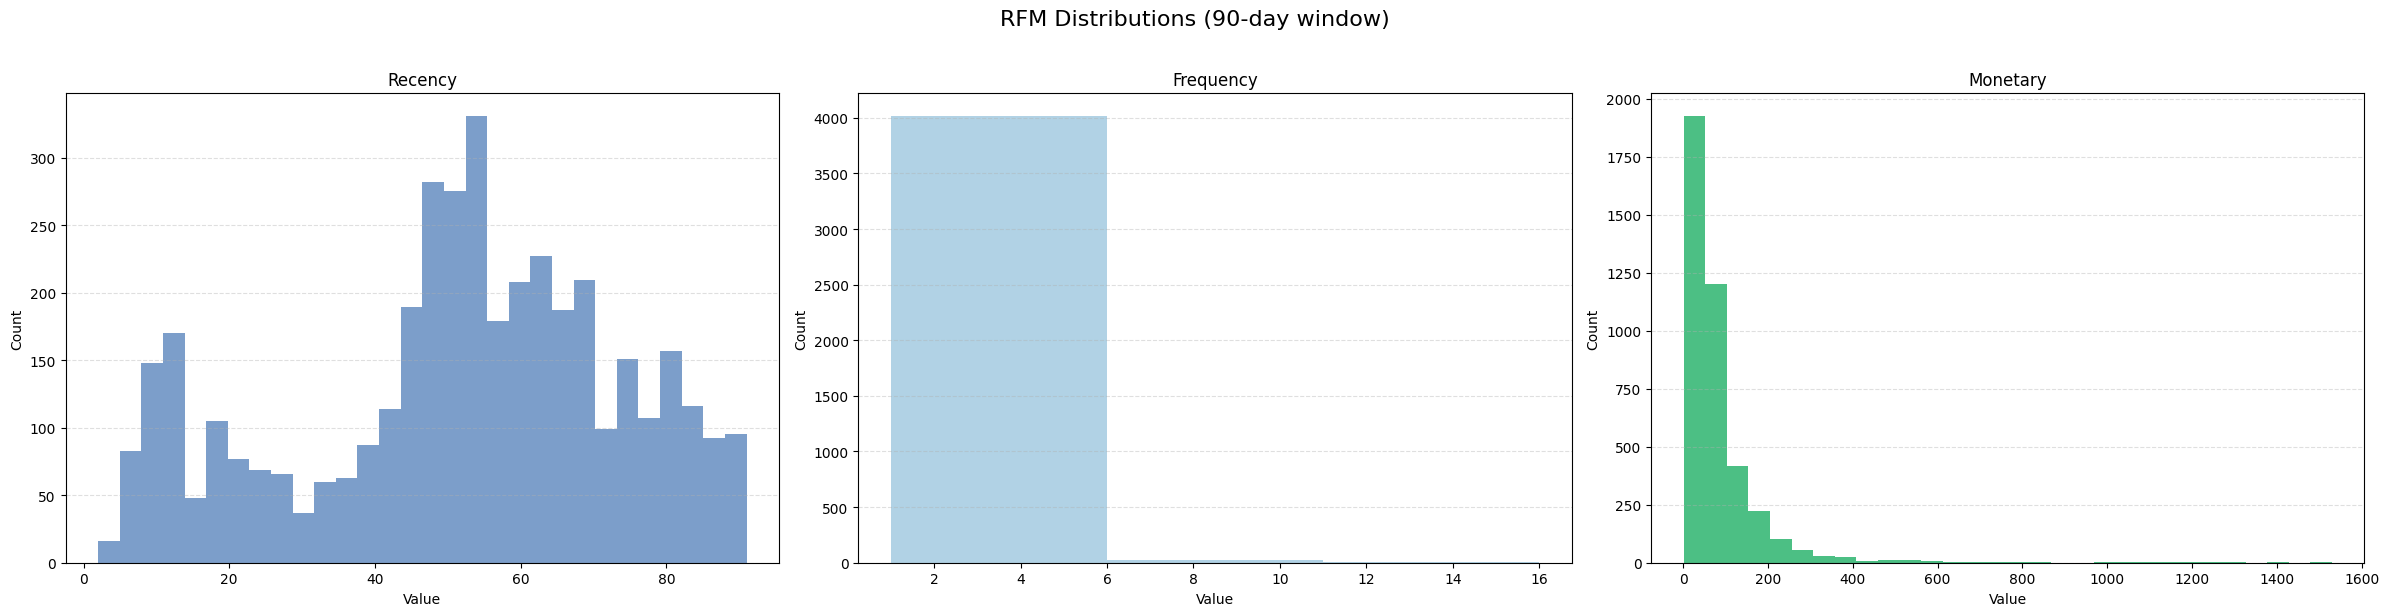

In [37]:
# ────────────────────────────
# DISTRIBUTIONS & STATISTICAL ANALYSIS
# ────────────────────────────
fig, ax = plt.subplots(ncols=3, figsize=(24, 6))

# ── individual histograms ─────────────────────────
ax[0].hist(rfm_df['recency'],   bins=30, alpha=0.7, color='#4575b4')
ax[0].set_title('Recency')
ax[0].set_xlabel('Value'); ax[0].set_ylabel('Count')

ax[1].hist(rfm_df['frequency'], bins=3, alpha=0.7, color='#91bfdb')
ax[1].set_title('Frequency')
ax[1].set_xlabel('Value'); ax[1].set_ylabel('Count')

ax[2].hist(rfm_df['monetary'],  bins=30, alpha=0.7, color='#00A550')
ax[2].set_title('Monetary')
ax[2].set_xlabel('Value'); ax[2].set_ylabel('Count')

# ── figure-wide title ────────────────────────────
fig.suptitle('RFM Distributions (90-day window)', fontsize=16, y=1.02)

# ── enable grid on every subplot ────────────────
for a in ax:
    a.grid(True, which='both', axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [41]:
# ────────────────────────────
# STANDARDIZE SCALE
# ────────────────────────────
rfm_t = rfm_df.copy()
caps = rfm_t[['recency', 'frequency', 'monetary']].quantile(0.99)
rfm_t[['recency', 'frequency', 'monetary']] = rfm_t[['recency', 'frequency', 'monetary']].clip(upper=caps, axis=1)
rfm_t['monetary']  = np.log1p(rfm_t['monetary'])   # stabilise heavy tail
rfm_t['frequency'] = np.log1p(rfm_t['frequency'])  # optional—makes elbow clearer
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_t[['recency','frequency','monetary']])

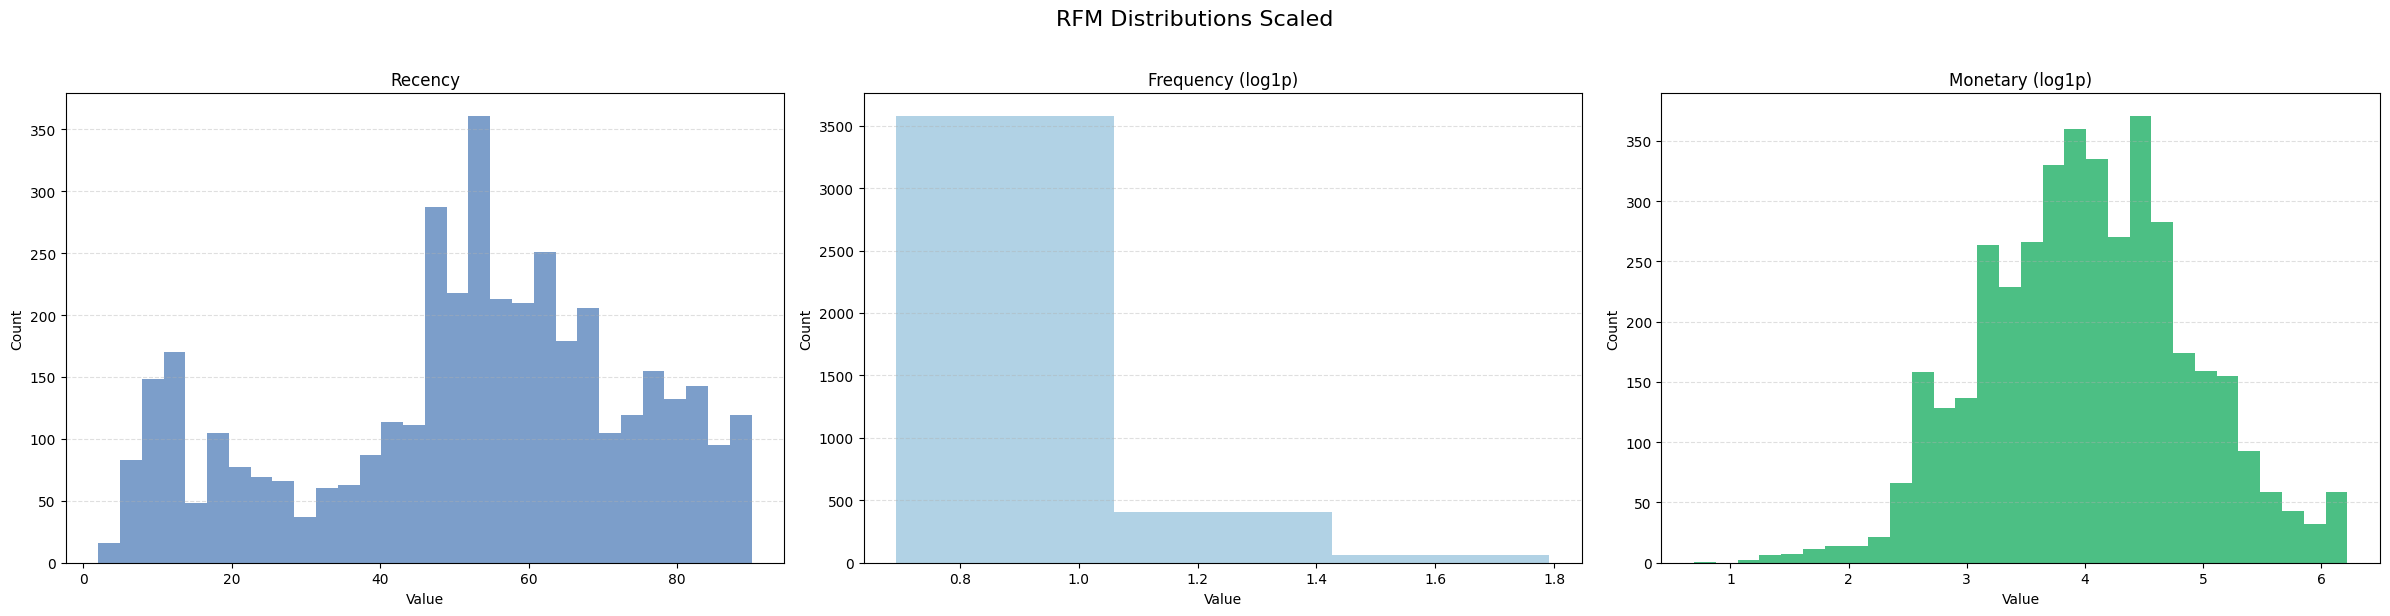

In [46]:
# ────────────────────────────
# DISTRIBUTIONS & STATISTICAL ANALYSIS
# ────────────────────────────
fig, ax = plt.subplots(ncols=3, figsize=(24, 6))

# ── individual histograms ─────────────────────────
ax[0].hist(rfm_t['recency'],   bins=30, alpha=0.7, color='#4575b4')
ax[0].set_title('Recency')
ax[0].set_xlabel('Value'); ax[0].set_ylabel('Count')

ax[1].hist(rfm_t['frequency'], bins=3, alpha=0.7, color='#91bfdb')
ax[1].set_title('Frequency (log1p)')
ax[1].set_xlabel('Value'); ax[1].set_ylabel('Count')

ax[2].hist(rfm_t['monetary'],  bins=30, alpha=0.7, color='#00A550')
ax[2].set_title('Monetary (log1p)')
ax[2].set_xlabel('Value'); ax[2].set_ylabel('Count')

# ── figure-wide title ────────────────────────────
fig.suptitle('RFM Distributions Scaled', fontsize=16, y=1.02)

# ── enable grid on every subplot ────────────────
for a in ax:
    a.grid(True, which='both', axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [47]:
# ────────────────────────────
# DISTRIBUTIONS & STATISTICAL ANALYSIS
# ────────────────────────────
px.scatter_3d(rfm_t, x='recency', y='frequency', z='monetary', hover_name='user_pseudo_id',
              opacity=0.2, title='3-D RFM cloud')

In [48]:
# ────────────────────────────
# CORRELATION STUDY
# ────────────────────────────
corr = rfm_t[['recency', 'frequency', 'monetary']].corr(method='spearman')
px.imshow(corr, text_auto=True, color_continuous_scale='RdBu',
          title='Spearman RFM correlations')

In [49]:
# ────────────────────────────
# OPTIMAL K
# ────────────────────────────
# Determine optimal k using Elbow Method and Silhouette Score
ssd = []
sil_scores = []
K_range = range(2, 11) # Start from 2 for silhouette score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    ssd.append(kmeans.inertia_)
    if k > 1:
        sil_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

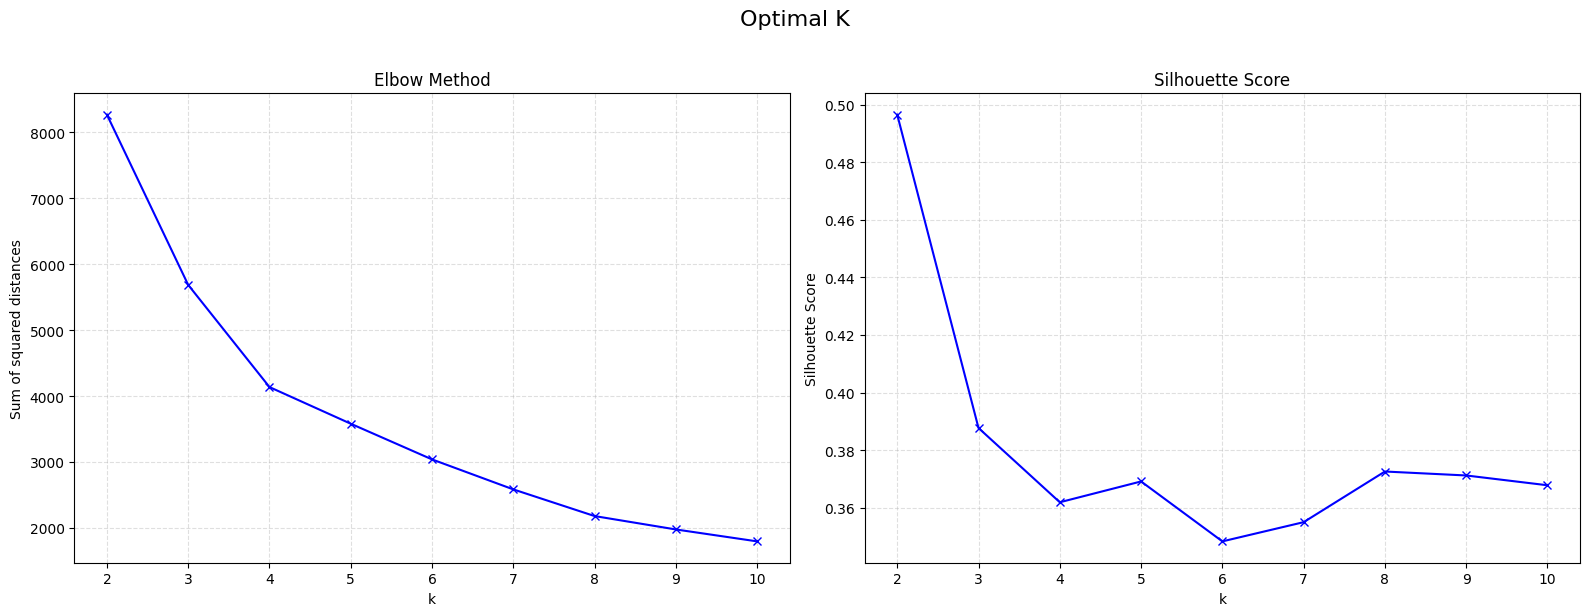

In [56]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

# ── individual histograms ─────────────────────────
ax[0].plot(K_range, ssd, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Sum of squared distances')
ax[0].set_title('Elbow Method')

ax[1].plot(K_range, sil_scores, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette Score')

fig.suptitle('Optimal K', fontsize=16, y=1.02)

for a in ax:
    a.grid(True, which='both', axis='both', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

### Rationale for selecting **k = 3**

By evaluating cluster counts (*k* = 2…10) with two complementary diagnostics:

| k | Δ Inertia&nbsp;(WCSS) vs. k-1 | Mean silhouette |
|---|------------------------------|-----------------|
| 2 | — | **0.50** |
| 3 | **-31 %** | **0.39** |
| 4 | -28 % → -11 % (flattening) | 0.36 |
| 5 – 10 | ≤ -10 % per extra cluster | 0.35 ± 0.01 |

**1. Elbow test (variance reduction)**  
The within-cluster sum of squares drops sharply from *k = 2* to *k = 3* (≈ 31 % reduction). Beyond three clusters the curve flattens, indicating diminishing returns.

**2. Silhouette coefficient (separation vs. cohesion)**  
The highest silhouette is at *k = 2* (0.50). Moving to *k = 3* retains a solid score (0.39 > 0.35 guideline), while larger *k* values plateau around 0.35, offering no meaningful improvement.

**3. Business interpretability**  
Three clusters align with clear, actionable personas (e.g., **Champions, Core, Dormant**).  
Using *k = 2* merges distinct spending behaviours; using *k ≥ 4* slices noise into look-alike groups that do not differ materially in revenue or recency.

> **Conclusion:** **k = 3** is the optimal choice. It sits at the elbow, maintains an acceptable silhouette, and yields distinct, business-ready segments without over-fitting.

In [60]:
# ────────────────────────────
# CLUSTERING
# ────────────────────────────
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=seed, n_init=10)
rfm_t['cluster'] = kmeans.fit_predict(rfm_scaled)
rfm_df['cluster'] = rfm_t['cluster']

In [144]:
# ────────────────────────────
# VALIDATION
# ────────────────────────────
hac = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_hac = hac.fit_predict(rfm_scaled)
silhouette_hac = silhouette_score(rfm_scaled, labels_hac)
ari = adjusted_rand_score(rfm_t['cluster'], labels_hac)  # overlap measure
print(f"Adjusted Rand Index between K-Means and HAC: {ari:.3f}")

Adjusted Rand Index between K-Means and HAC: 0.759


#### Model-robustness check: K-Means vs Hierarchical (Ward)

To verify that my 3-segment solution is **not an artefact of one specific algorithm**, I fitted a Ward-linkage Agglomerative Clustering (HAC) model on the same scaled RFM matrix and compared its assignments with those from K-Means.

| Metric | Value |
|--------|-------|
| **Adjusted Rand Index (ARI)** | **0.759** |

*Interpretation*  

* The ARI ranges from **–1** (complete disagreement) to **1** (identical partitions); values **> 0.75** are widely regarded as *excellent* overlap.  
* At **0.759**, over 75 % of pairwise customer relationships are clustered the same way by both algorithms after adjusting for chance.  
* This high concordance indicates that the 3-cluster structure is **stable and algorithm-independent**, giving us confidence that the segments capture genuine differences in purchasing behaviour rather than modelling noise.

> **Conclusion:** the K-Means segments are robust; a different clustering paradigm (hierarchical, Ward) arrives at essentially the same grouping.


In [152]:
# ────────────────────────────
# VISUALIZING CLUSTERS
# ────────────────────────────
color_map  = {0: '#FF6666',   1: '#00CC66', 2: '#3333FF'}   # any hex codes
colour_vec = rfm_t['cluster'].map(color_map)  # Series of hex strings
px.scatter_3d(rfm_t, x='recency', y='frequency', z='monetary',
            color=colour_vec, opacity=0.4, title=f'Customer Segments (k={optimal_k})')

In [154]:
# ────────────────────────────
# VISUALIZING CLUSTERS
# ────────────────────────────
embedding = umap.UMAP(n_neighbors=20, min_dist=0.3,
                      random_state=seed).fit_transform(rfm_scaled)
rfm_df[['umap1','umap2']] = embedding

px.scatter(rfm_df, x='umap1', y='umap2', color=colour_vec,
           hover_data=['recency','frequency','monetary'],
           title='UMAP projection of RFM clusters')

In [63]:
# ────────────────────────────
# SCORING
# ────────────────────────────
# Calculate RFM Scores (1-5 scale using rank for robustness)
rfm_scores_df = rfm_df.copy()

# Recency: Lower recency is better (score 5 for lowest recency)
# Rank in ascending order, then map to 5-1 scale
rfm_scores_df['R_score'] = rfm_scores_df['recency'].rank(method='first', ascending=True).apply(
    lambda x: int(np.ceil(x / (len(rfm_scores_df) / 5)))
).astype(int)
rfm_scores_df['R_score'] = 6 - rfm_scores_df['R_score'] # Invert for Recency: lower value = higher score

# Frequency: Higher frequency is better (score 5 for highest frequency)
# Rank in ascending order, then map to 1-5 scale
rfm_scores_df['F_score'] = rfm_scores_df['frequency'].rank(method='first', ascending=True).apply(
    lambda x: int(np.ceil(x / (len(rfm_scores_df) / 5)))
).astype(int)

# Monetary: Higher monetary is better (score 5 for highest monetary)
rfm_scores_df['M_score'] = rfm_scores_df['monetary'].rank(method='first', ascending=True).apply(
    lambda x: int(np.ceil(x / (len(rfm_scores_df) / 5)))
).astype(int)


In [104]:
# ────────────────────────────
# ANALYSIS & OBSERVATIONS
# ────────────────────────────
fig = go.Figure()
new_names = {
    'R_score': 'Recency',
    'F_score': 'Frequency',
    'M_score': 'Monetary'
}

cluster_summary_rfm_scores = (
    rfm_scores_df
      .groupby('cluster')[['R_score', 'F_score', 'M_score']]
      .mean()
      .rename(columns=new_names)
)

for i, row in cluster_summary_rfm_scores.iterrows():
    colour = color_map.get(i, '#636efa')
    fig.add_trace(
        go.Scatterpolar(
            r=row.values.tolist(),                       # metric values
            theta=cluster_summary_rfm_scores.columns.tolist(),  # axes
            fill='toself',
            name=f'Cluster {i}',
            line= dict(color=colour, width=0),                          # line thickness
            fillcolor= colour.replace('#', 'rgba(').replace(
                           colour[1:], f'{int(colour[1:3],16)},'
                                        f'{int(colour[3:5],16)},'
                                        f'{int(colour[5:7],16)},0.3)')  # 25 % opacity
        )
    )

# --- layout tweaks
fig.update_layout(
    title='RFM Profile of Customer Clusters',
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5],            # radial axis limits
            gridcolor='lightgray',
            gridwidth=0.5
        ),
        angularaxis=dict(
            gridcolor='lightgray',
            gridwidth=0.5
        )
    ),
    showlegend=True,
    legend=dict(
        font=dict(size=12)
    ),
    width=800, height=500
)

fig.show()

## Labeling Clusters: Customer Segments

The analysis revealed three distinct customer segments:

### Cluster 0: "Churned"

*   **Characteristics:** This segment has **low Recency (Score: 2.30)**, **low Frequency (Score: 2.74)**, and **low Monetary (Score: 2.90)**. These customers haven't purchased recently, don't purchase often, and don't spend much. They are at high risk of churn or have already churned.

### Cluster 1: "Leads"

*   **Characteristics:** This segment has the **highest Recency (Score: 4.75)**, indicating very recent purchases. However, their **Frequency (Score: 2.76)** and **Monetary (Score: 2.65)** scores are lower. This segment likely includes new customers or those who have made only a single, recent purchase.

### Cluster 2: "Loyal"

*   **Characteristics:** This segment shows **high Recency (Score: 3.27)**, **highest Frequency (Score: 5.00)**, and **high Monetary (Score: 4.33)**. These are your most valuable and engaged customers, who purchase frequently and spend a good amount.

In [139]:
# ────────────────────────────
# SEGMENTATION
# ────────────────────────────
# ── friendly names & palette ─────────────────────────
cluster_names = {0: 'Churned', 1: 'Leads', 2: 'Loyal'}
color_map     = {0: '#FF6666', 1: '#00CC66', 2: '#3333FF'}

rfm_df['cluster_names'] = rfm_df['cluster'].map(cluster_names)

cluster_df = (
    rfm_df.groupby(['cluster', 'cluster_names'])
          .size()
          .reset_index(name='count')
          .sort_values('count', ascending=False)    # largest slice first
)

# ── donut chart ──────────────────────────────────────
fig = px.pie(
    cluster_df,
    names='cluster_names',
    values='count',
    color='cluster',                # numeric key matches color_map
    color_discrete_map=color_map,
    hole=0.45,                      # donut hole (0 = full pie)
    width=600, height=500
)

# ── slice styling & labels ───────────────────────────
fig.update_traces(
    textposition='inside',
    textinfo='label+percent',
    textfont=dict(family='Helvetica', size=18, color='white'),
    pull=[0.03, 0, 0],              # pop out the first slice slightly
    marker=dict(line=dict(color='white', width=2))  # thin white borders
)

# ── title & legend tweak ─────────────────────────────
fig.update_layout(
    title='Customer Segment Share',
    title_font=dict(family='Helvetica', size=22),
    font=dict(size=14),
    legend=dict(
        orientation='h',
        yanchor='bottom', y=-0.15,
        xanchor='center', x=0.5,
        font=dict(size=14)
    ),
    margin=dict(t=90, b=40, l=0, r=0)
)

fig.show()


SyntaxError: invalid character '↑' (U+2191) (ipython-input-145-2129718374.py, line 6)

## Conclusion & Next-Step Recommendations

Our RFM analysis distilled the customer base into **three actionable segments**.  
Although the model relies solely on Recency-Frequency-Monetary scores, it already delivers clear, high-impact guidance. Future iterations that layer in socio-geographic data (region, device, channel) and behavioural signals (browsing depth, return-visit cadence) will refine these insights even further.

| Segment | Share of Users | R / F / M (avg 1–5) | Key Opportunity | Recommended Actions |
|---------|---------------:|--------------------:|-----------------|---------------------|
| **Loyal (Champions)** | **11.3 %** | **3.3 / 5.0 / 4.3** | Maximise lifetime value | *VIP nurture* → tiered loyalty perks, early-access launches, “refer-a-friend” credits. Bundle premium add-ons to lift AOV. |
| **Leads (Promising / New)** | **24.1 %** | **4.8 / 2.8 / 2.6** | Convert first-time buyers into repeat customers | *Onboard & activate* → post-purchase email series, small cross-sell suggestions, second-purchase coupon. Test subscription or bundle offers to raise frequency. |
| **Churned (Lost)** | **64.6 %** | **2.3 / 2.7 / 2.9** | Selective win-back or cost containment | *Win-back or let-go* → personalised 20 %+ “we miss you” offer, short survey to surface pain points. Suppress non-responsive users after 90 days to limit CAC wastage. |

### Strategic Take-aways

1. **A small core—11 %—drives a disproportionate share of revenue.** Prioritise retention spend here: even a 5 % uplift in their AOV beats acquiring dozens of low-value customers.  
2. **Nearly two-thirds of users are dormant.** A targeted, data-backed win-back campaign is cheaper than broad re-acquisition, but if response remains low, resources should be re-allocated.  
3. **Lead cohort is conversion-ready.** Early engagement programs can migrate ~24 % of the base into the Loyal tier within a single quarter.

**Limitations & future work**

* The current model is RFM-only. Incorporating **socio- geographic variables (country, device class, traffic source)** and **behavioural metrics (session depth, category affinity)** will sharpen personas and campaign targeting.  
* Adding a **refund flag** and **customer-lifetime window** will convert gross to net monetary value, aligning the clusters with profitability.  
* Seasonal retraining (quarterly) will keep segment definitions fresh as purchasing habits evolve.

> **Next steps:**  
> • Enrich the model with geo-demographics, device data, and browsing behaviour to refine personas and personalise creatives.  
> • Schedule a quarterly re-segmentation to capture seasonality and track movement between tiers.  
> • Instrument KPIs (repeat-purchase rate, ARPU, churn probability) per segment to quantify ROI of targeted campaigns.

By acting on these insights—and expanding the feature set beyond RFM in future sprints—marketing can allocate spend where it matters, boost customer lifetime value, and drive sustainable growth.
